# Імпорт необхідних бібліотек

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Завантаження датасету

In [70]:
data_path = "Automobile.csv"
#encoding = 'windows-1251'
data = pd.read_csv(data_path)
df_original = data.copy()
missing_data = data.isnull().sum()

if missing_data.sum() > 0:
    print("\nПропущені значення виявлено. Видаляємо їх...")
    data = data.dropna()
def detect_outliers(df):
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    
    return outliers

#df_original = data.copy()
# Порівнюємо індекси початкового (df_original) та очищеного (data) датафреймів
# 1. Отримуємо індекси рядків, що залишилися в очищеному датафреймі
#retained_indices = data.index.tolist()

# 2. Отримуємо індекси рядків, які БУЛИ видалені
# Індекси видалених = Індекси оригінального DF мінус Індекси очищеного DF
deleted_indices = df_original.index.difference(data.index)

# 3. Вибираємо видалені рядки з початкового датафрейму
df_deleted_rows = df_original.loc[deleted_indices]

print("\n--- Видалені рядки")
print(f"Загальна кількість видалених рядків: {len(df_deleted_rows)}")
print(df_deleted_rows)
print("\nПеревірка наявності викидів:")
outliers = detect_outliers(data)
outliers.sum()
data.info()

#data = pd.read_csv(data_path, encoding=encoding)
#data = pd.read_csv(data_path)
print(data.head())


Пропущені значення виявлено. Видаляємо їх...

--- Видалені рядки
Загальна кількість видалених рядків: 6
                     name   mpg  cylinders  displacement  horsepower  weight  \
32             ford pinto  25.0          4          98.0         NaN    2046   
126         ford maverick  21.0          6         200.0         NaN    2875   
330  renault lecar deluxe  40.9          4          85.0         NaN    1835   
336    ford mustang cobra  23.6          4         140.0         NaN    2905   
354           renault 18i  34.5          4         100.0         NaN    2320   
374        amc concord dl  23.0          4         151.0         NaN    3035   

     acceleration  model_year  origin  
32           19.0          71     usa  
126          17.0          74     usa  
330          17.3          80  europe  
336          14.3          80     usa  
354          15.8          81  europe  
374          20.5          82     usa  

Перевірка наявності викидів:
<class 'pandas.core.fram

# Візуалізація даних

## Heatmap кореляцій

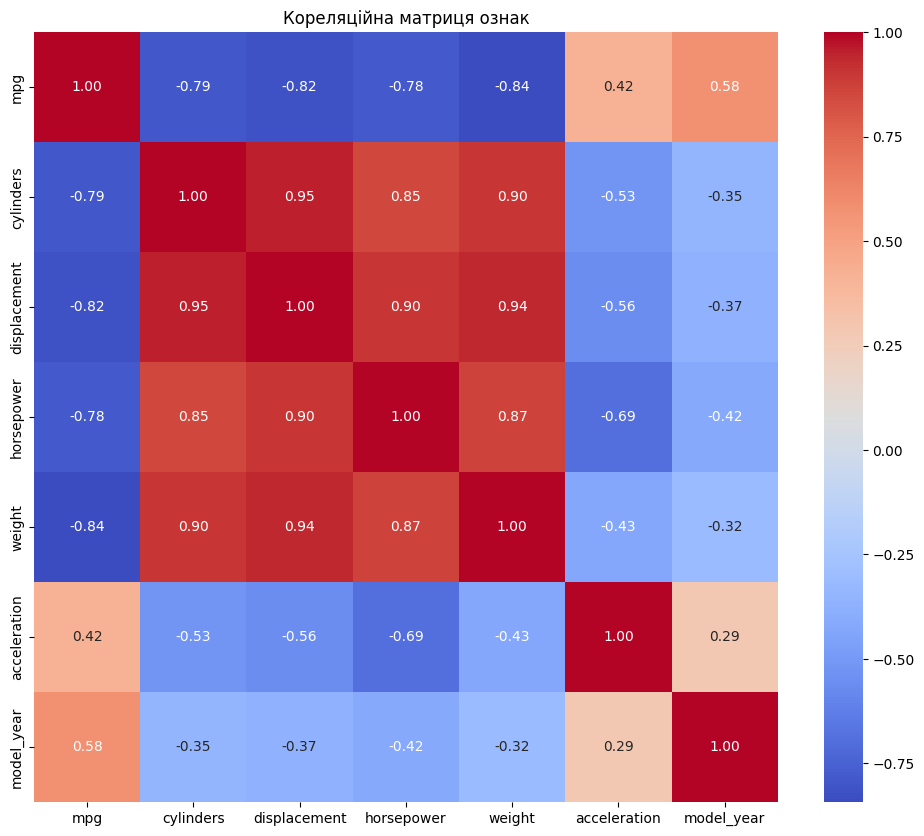

In [71]:
#data = data.drop(data.columns[[8, 7, 6, 2, 1]], axis=1)
data = data.drop(data.columns[[8, 0]], axis=1)
data = data[(data['cylinders'] != 3) & (data['cylinders'] != 5)]

correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляційна матриця ознак')
plt.show()

## Гістограми розподілу ознак

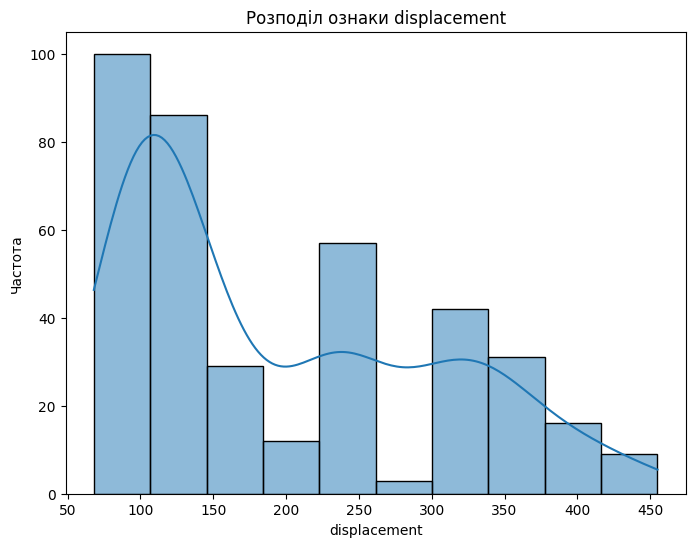

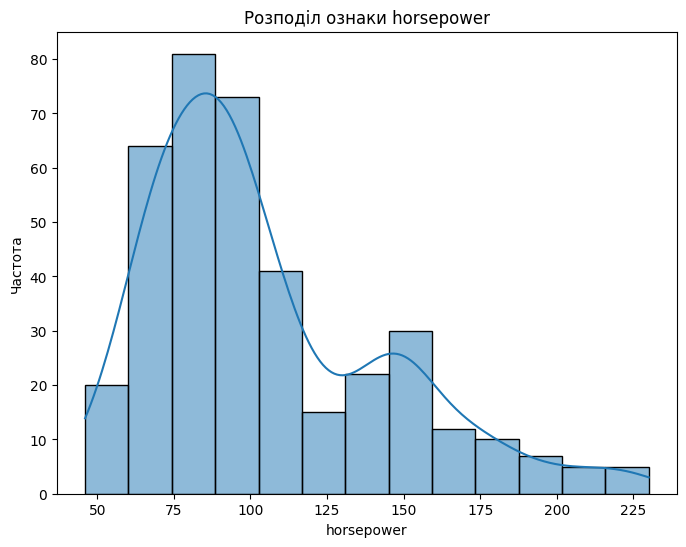

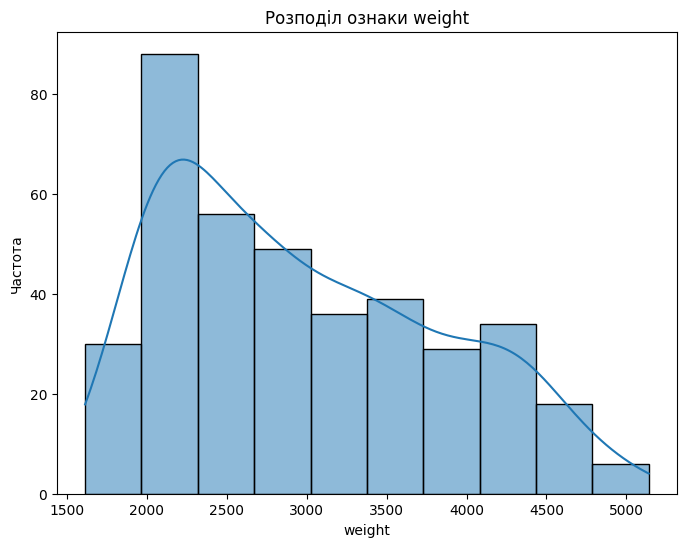

In [72]:
#features = ['purchase_lead', 'length_of_stay', 'flight_hour']
features = ['displacement', 'horsepower', 'weight']
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Розподіл ознаки {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

## Boxplot

cylinders
4    199
8    103
6     83
Name: count, dtype: int64


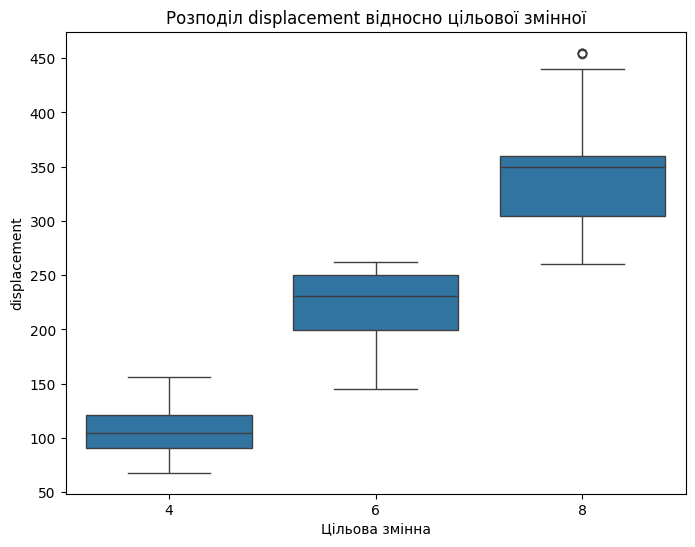

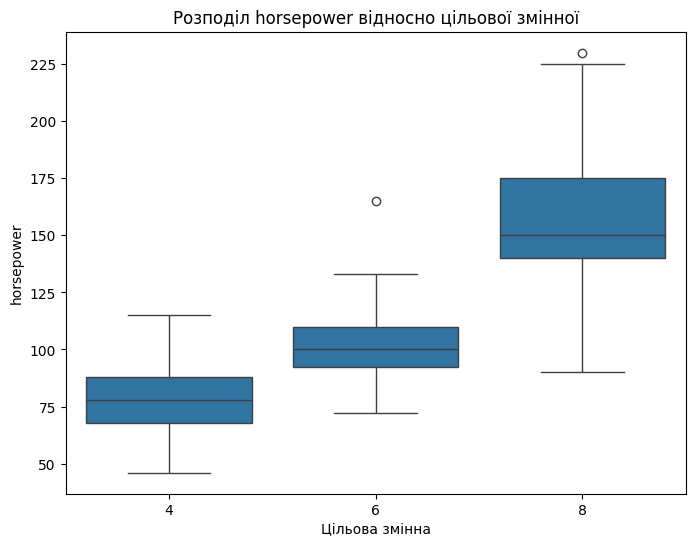

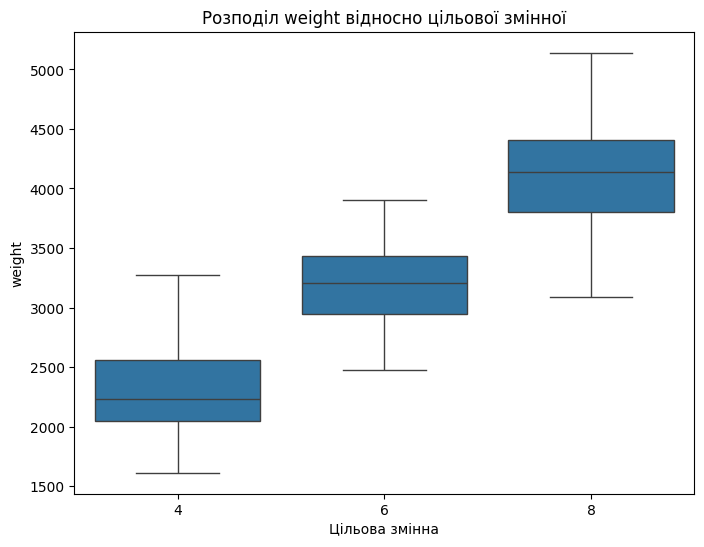

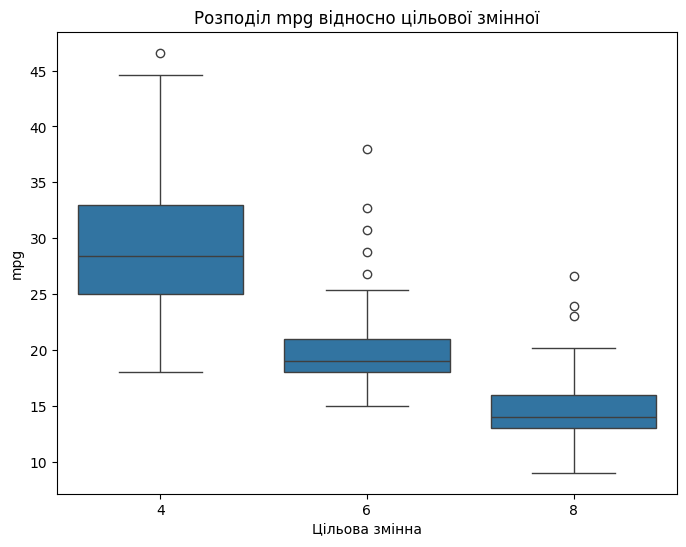

In [73]:
counts = data['cylinders'].value_counts()

print(counts)
features_to_plot = ['displacement', 'horsepower', 'weight', 'mpg']
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cylinders', y=feature, data=data)
    plt.title(f'Розподіл {feature} відносно цільової змінної')
    plt.xlabel('Цільова змінна')
    plt.ylabel(feature)
    plt.show()

# Поділ на набори

In [74]:
label_encoder = LabelEncoder()
data['cylinders'] = label_encoder.fit_transform(data['cylinders'])
print(data['cylinders'].value_counts())
X = data.drop(columns=['cylinders'])
y = data['cylinders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Підготовка даних завершена. Розміри наборів:")
print(f"Тренувальні ознаки (X_train): {X_train.shape}")
print(f"Тестові ознаки (X_test): {X_test.shape}")

cylinders
0    199
2    103
1     83
Name: count, dtype: int64
Підготовка даних завершена. Розміри наборів:
Тренувальні ознаки (X_train): (269, 6)
Тестові ознаки (X_test): (116, 6)


# kNN


--- Результати пошуку оптимального kNN ---
  n_neighbors  Mean F1-Score  Rank
2           5       0.959617     1
1           3       0.954852     2
0           1       0.947080     3
3           7       0.936065     4
9          19       0.933421     5
4           9       0.931964     6
5          11       0.931964     6
6          13       0.929130     8
7          15       0.923912     9
8          17       0.923912     9
Найкращі параметри для kNN: {'n_neighbors': 5}

--- kNN Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.91      0.84      0.87        25
           2       1.00      0.94      0.97        31

    accuracy                           0.95       116
   macro avg       0.95      0.93      0.94       116
weighted avg       0.95      0.95      0.95       116

Confusion Matrix:


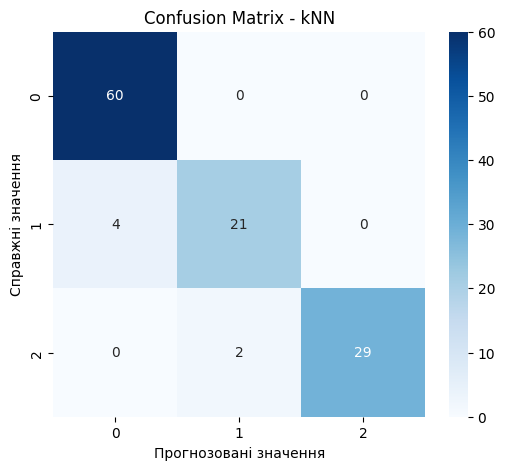

In [90]:
param_grid_knn = {'n_neighbors': np.arange(1, 21, 2)} # Перевіряємо непарні значення від 1 до 20

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

results_knn = pd.DataFrame(grid_search_knn.cv_results_)
results_knn = results_knn[['param_n_neighbors', 'mean_test_score', 'rank_test_score']]

results_knn = results_knn.sort_values(by='rank_test_score')
results_knn.columns = ['n_neighbors', 'Mean F1-Score', 'Rank']

print("\n--- Результати пошуку оптимального kNN ---")
print(results_knn)

best_knn = grid_search_knn.best_estimator_
print(f"Найкращі параметри для kNN: {grid_search_knn.best_params_}")

y_pred_knn = best_knn.predict(X_test)

print("\n--- kNN Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("Confusion Matrix:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - kNN")
plt.ylabel("Справжні значення")
plt.xlabel("Прогнозовані значення")
plt.show()

# Decision Tree


--- Decision Tree Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.92      0.96        25
           2       1.00      1.00      1.00        31

    accuracy                           0.98       116
   macro avg       0.99      0.97      0.98       116
weighted avg       0.98      0.98      0.98       116

Confusion Matrix:


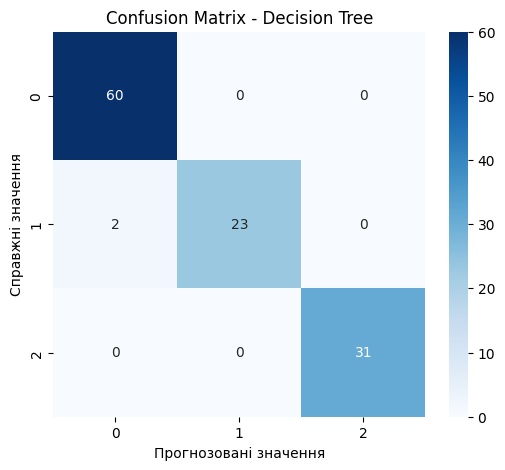

In [83]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
print("\n--- Decision Tree Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.ylabel("Справжні значення")
plt.xlabel("Прогнозовані значення")
plt.show()

# SVM

Найкращі параметри для SVM: {'C': 10, 'gamma': 0.1}

--- Результати пошуку оптимальних C та Gamma для SVM ---
     C  Gamma  Mean F1-Score  Rank
6   10    0.1       0.972079     1
7   10   0.01       0.958862     2
3    1    0.1       0.958543     3
4    1   0.01       0.921293     4
8   10  0.001       0.921293     4
0  0.1    0.1       0.861231     6
5    1  0.001       0.596140     7
1  0.1   0.01       0.589694     8
2  0.1  0.001       0.227120     9

--- SVM Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.88      0.92      0.90        25
           2       1.00      0.90      0.95        31

    accuracy                           0.96       116
   macro avg       0.95      0.94      0.94       116
weighted avg       0.96      0.96      0.96       116

Confusion Matrix:


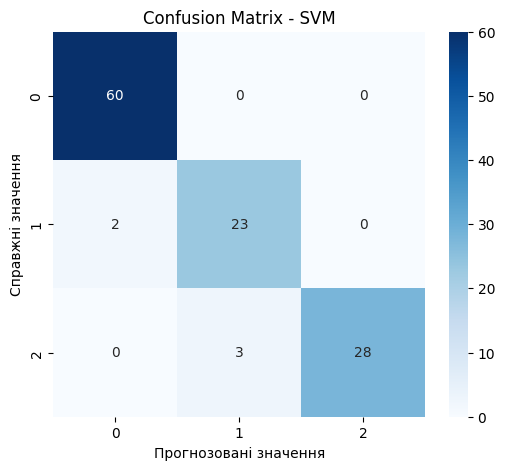

In [87]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
}

svm = SVC(kernel='rbf', random_state=42)

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
print(f"Найкращі параметри для SVM: {grid_search_svm.best_params_}")

results_svm = pd.DataFrame(grid_search_svm.cv_results_)
results_svm = results_svm[['param_C', 'param_gamma', 'mean_test_score', 'rank_test_score']]
results_svm = results_svm.sort_values(by='rank_test_score')
results_svm.columns = ['C', 'Gamma', 'Mean F1-Score', 'Rank']

print("\n--- Результати пошуку оптимальних C та Gamma для SVM ---")
print(results_svm)

y_pred_svm = best_svm.predict(X_test)

print("\n--- SVM Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.ylabel("Справжні значення")
plt.xlabel("Прогнозовані значення")
plt.show()

# Random Forest


--- Random Forest Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.88      0.94        25
           2       1.00      1.00      1.00        31

    accuracy                           0.97       116
   macro avg       0.98      0.96      0.97       116
weighted avg       0.98      0.97      0.97       116

Confusion Matrix:


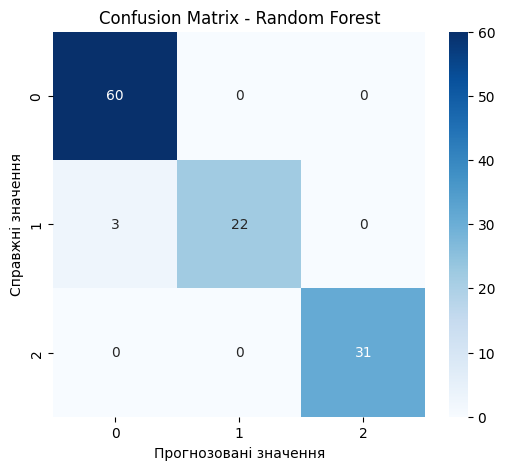

In [78]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

print("\n--- Random Forest Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("Справжні значення")
plt.xlabel("Прогнозовані значення")
plt.show()

# AdaBoost


--- AdaBoost Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.88      0.88      0.88        25
           2       1.00      0.90      0.95        31

    accuracy                           0.95       116
   macro avg       0.94      0.93      0.93       116
weighted avg       0.95      0.95      0.95       116

Confusion Matrix:


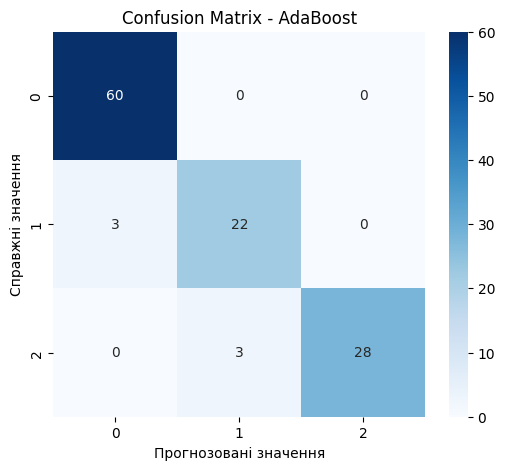

In [79]:
ab_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
ab_classifier.fit(X_train, y_train)

y_pred_ab = ab_classifier.predict(X_test)

print("\n--- AdaBoost Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_ab))

print("Confusion Matrix:")
cm_ab = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ab, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - AdaBoost")
plt.ylabel("Справжні значення")
plt.xlabel("Прогнозовані значення")
plt.show()